In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn import metrics

In [3]:
vb = pd.read_csv("../data/vb_data_3_numZone.csv")
vb_c = pd.read_csv("../data/vb_data_3_categZone.csv")
q_values_raw = pickle.load(open('../output/q_values_new.pkl', 'rb'))
q_values = np.asarray([q_values_raw[i,0] for i in range(len(q_values_raw))])
# clipping
q_values[q_values>1] = 1
q_values[q_values<-1] = -1
y_prob_tree = pickle.load(open('../output/y_probabilities_tree.pkl', 'rb'))
q_tree = y_prob_tree[:,1]*2 - 1
q_mimic = pickle.load(open('../output/q_values_mimictree.pkl', 'rb'))
q_forest = pickle.load(open('../output/q_forest.pkl', 'rb'))

In [9]:
# fix team names
vb.loc[vb.PlayerTeam=='TWU', 'PlayerTeam'] = 'Trinity Western'
vb.loc[vb.PlayerTeam=='TRU', 'PlayerTeam'] = 'Thompson Rivers'
vb.loc[vb.PlayerTeam=='MRU', 'PlayerTeam'] = 'Mount Royal'

##### Basic Miscellaneous

In [4]:
n = 0
prevDist = -1
for i in range(len(vb)):
    if vb.RewardDistance[i] >= prevDist:
        n += 1
    prevDist = vb.RewardDistance[i]
print(n, 'total rallies')

34371 total rallies


In [9]:
from sklearn import metrics
true_prob = np.zeros([len(vb),2])
true_prob[:,0] = .5-.5*vb.RewardValue
true_prob[:,1] = 1 - true_prob[:,0]
nn_prob = np.zeros([len(vb),2])
nn_prob[:,0] = .5-.5*q_values
nn_prob[:,1] = 1 - nn_prob[:,0]

print('Cross entropy loss for NN: %.3f' % (metrics.log_loss(true_prob,nn_prob,eps=1e-4)))
print('Cross entropy loss for Tree: %.3f' % (metrics.log_loss(true_prob,y_prob_tree,eps=1e-4)))
print('\n')
print('Mean squared error for NN: %.3f' % (metrics.mean_squared_error(true_prob,nn_prob)))
print('Mean squared error for Tree: %.3f' % (metrics.mean_squared_error(true_prob,y_prob_tree)))
print('\n')
print('ROC-AUC score for NN: %.3f' % (metrics.roc_auc_score(true_prob,nn_prob)))
print('ROC-AUC score for Tree: %.3f' % (metrics.roc_auc_score(true_prob,y_prob_tree)))

Cross entropy loss for NN: 0.429
Cross entropy loss for Tree: 0.435


Mean squared error for NN: 0.151
Mean squared error for Tree: 0.153


ROC-AUC score for NN: 0.853
ROC-AUC score for Tree: 0.849


##### Set by Location

In [3]:
print('\nHome set by execution zone:')
for zone in ['3A','3B','3C','3D','2A','2B','2C','2D','4A','4B','4C','4D','9B','9C','8B','8C','7B','7C']:
    cond = (vb_c['ActionType0']=='E') & (vb_c['ActionHome0']==1) & (vb_c['ActionStartZone0']=='Z'+zone)
    print('%s: avg probability %.1f%% (actual %.1f%% out of %d)' % \
          (zone, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))
    
print('\nHome receive by end zone:')
for zone in ['3A','3B','3C','3D','2A','2B','2C','2D','4A','4B','4C','4D','9B','9C','8B','8C','7B','7C']:
    cond = (vb_c['ActionType0']=='R') & (vb_c['ActionHome0']==1) & (vb_c['ActionEndZone0']=='Z'+zone)
    print('%s: avg probability %.1f%% (actual %.1f%% out of %d)' % \
          (zone, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond))) 


Home set by execution zone:
3A: avg probability 65.6% (actual 67.0% out of 1700)
3B: avg probability 69.6% (actual 72.6% out of 2108)
3C: avg probability 67.5% (actual 68.4% out of 757)
3D: avg probability 65.1% (actual 62.7% out of 644)
2A: avg probability 62.4% (actual 62.2% out of 201)
2B: avg probability 64.8% (actual 61.7% out of 154)
2C: avg probability 68.8% (actual 70.6% out of 646)
2D: avg probability 65.3% (actual 67.4% out of 651)
4A: avg probability 63.4% (actual 63.1% out of 168)
4B: avg probability 64.9% (actual 68.3% out of 167)
4C: avg probability 62.7% (actual 60.0% out of 10)
4D: avg probability 59.8% (actual 38.5% out of 13)
9B: avg probability 56.5% (actual 45.5% out of 33)
9C: avg probability 57.0% (actual 57.3% out of 117)
8B: avg probability 57.5% (actual 61.4% out of 197)
8C: avg probability 56.5% (actual 65.7% out of 108)
7B: avg probability 56.4% (actual 50.0% out of 48)
7C: avg probability 58.9% (actual 66.7% out of 3)

Home receive by end zone:
3A: avg prob

##### R# and R+ actions by score

In [17]:
print('\nHome R# by score:')
for score in range(5,26,5): #['Z3','Z4','Z2','Z9','Z8']:
    cond = (vb['ActionType0']=='R') & (vb['ActionOutcome0']=='#') & (vb['ActionHome0']==1) & (vb['ScoreMax']<score) & (vb['ScoreMax']>=score-5)
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (score, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))

print('\nHome R+ by score:')
for score in range(5,26,5): #['Z3','Z4','Z2','Z9','Z8']:
    cond = (vb['ActionType0']=='R') & (vb['ActionOutcome0']=='+') & (vb['ActionHome0']==1) & (vb['ScoreMax']<score) & (vb['ScoreMax']>=score-5)
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (score, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))
    
print('\nHome R# by score diff:')
for diff in range(-4,5):
    cond = (vb['ActionType0']=='R') & (vb['ActionOutcome0']=='#') & (vb['ActionHome0']==1) & (vb['ScoreDiff']==diff)
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (diff, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))

print('\nHome R+ by score:')
for diff in range(-4,5):
    cond = (vb['ActionType0']=='R') & (vb['ActionOutcome0']=='+') & (vb['ActionHome0']==1) & (vb['ScoreDiff']==diff)
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (diff, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))


Home R# by score:
5: avg probability 70.5% (from data: 73.1% out of 453)
10: avg probability 70.5% (from data: 72.1% out of 498)
15: avg probability 70.7% (from data: 70.7% out of 543)
20: avg probability 70.7% (from data: 72.3% out of 519)
25: avg probability 71.2% (from data: 73.4% out of 508)

Home R+ by score:
5: avg probability 65.0% (from data: 68.5% out of 951)
10: avg probability 65.0% (from data: 65.2% out of 1044)
15: avg probability 65.0% (from data: 65.1% out of 1129)
20: avg probability 65.1% (from data: 64.0% out of 1100)
25: avg probability 65.2% (from data: 68.0% out of 1055)

Home R# by score diff:
-4: avg probability 71.9% (from data: 73.0% out of 89)
-3: avg probability 71.7% (from data: 66.0% out of 162)
-2: avg probability 71.2% (from data: 69.7% out of 234)
-1: avg probability 71.0% (from data: 71.7% out of 258)
0: avg probability 70.8% (from data: 71.7% out of 406)
1: avg probability 70.3% (from data: 70.6% out of 367)
2: avg probability 70.1% (from data: 74.8% 

##### Float and Spin Serve by Score

In [60]:
cond = (vb['ActionType0']=='S') & (vb['ActionSpeed0']==-1) & (vb['ActionHome0']==1)
print('Home float avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))
cond = (vb['ActionType0']=='S') & (vb['ActionSpeed0']==1) & (vb['ActionHome0']==1)
print('Home spin avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))
cond = (vb['ActionType0']=='S') & (vb['ActionSpeed0']==-1) & (vb['ActionAway0']==1)
print('Away float avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (50-50*np.mean(q_values[cond], axis=0), 50-50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))
cond = (vb['ActionType0']=='S') & (vb['ActionSpeed0']==1) & (vb['ActionAway0']==1)
print('Away spin avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (50-50*np.mean(q_values[cond], axis=0), 50-50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))

print('\nHome float serve by score:')
for score in range(5,26,5): #['Z3','Z4','Z2','Z9','Z8']:
    cond = (vb['ActionType0']=='S') & (vb['ActionSpeed0']==-1) & (vb['ActionHome0']==1) & (vb['ScoreMax']<score) & (vb['ScoreMax']>=score-5)
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (score, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))

print('\nHome spin serve by score:')
for score in range(5,26,5): #['Z3','Z4','Z2','Z9','Z8']:
    cond = (vb['ActionType0']=='S') & (vb['ActionSpeed0']==1) & (vb['ActionHome0']==1) & (vb['ScoreMax']<score) & (vb['ScoreMax']>=score-5)
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (score, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))
    
print('\nHome float serve by score diff:')
for diff in range(-4,5):
    cond = (vb['ActionType0']=='S') & (vb['ActionSpeed0']==-1) & (vb['ActionHome0']==1) & (vb['ScoreDiff']==diff)
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (diff, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))

print('\nHome spin serve by score diff:')
for diff in range(-4,5):
    cond = (vb['ActionType0']=='S') & (vb['ActionSpeed0']==1) & (vb['ActionHome0']==1) & (vb['ScoreDiff']==diff)
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (diff, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))

Home float avg probability 39.2% (from data: 39.8% out of 12489)
Home spin avg probability 37.6% (from data: 38.0% out of 5081)
Away float avg probability 37.6% (from data: 37.1% out of 12197)
Away spin avg probability 34.2% (from data: 33.6% out of 4604)

Home float serve by score:
5: avg probability 40.1% (from data: 40.8% out of 2291)
10: avg probability 39.4% (from data: 40.4% out of 2400)
15: avg probability 38.8% (from data: 39.3% out of 2581)
20: avg probability 39.2% (from data: 38.7% out of 2480)
25: avg probability 38.4% (from data: 39.9% out of 2600)

Home spin serve by score:
5: avg probability 37.9% (from data: 39.1% out of 818)
10: avg probability 38.2% (from data: 38.0% out of 1204)
15: avg probability 37.3% (from data: 37.3% out of 1083)
20: avg probability 37.4% (from data: 39.6% out of 974)
25: avg probability 37.7% (from data: 37.1% out of 950)

Home float serve by score diff:
-4: avg probability 40.4% (from data: 41.1% out of 880)
-3: avg probability 40.2% (from dat

##### Middle set by score

In [37]:
print('\nHome middle set by score:')
for score in range(5,26,5):
    cond = (vb_c['ActionType0']=='E') & \
           (vb_c['ActionHome0']==1) & \
           (vb_c['ActionEndZone0']=='Z'+zone) & \
           (vb['ScoreMax']<score) & (vb['ScoreMax']>=score-5)
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (score, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))


Home middle set by score:
5: avg probability 67.8% (from data: 74.7% out of 95)
10: avg probability 67.6% (from data: 73.7% out of 118)
15: avg probability 67.4% (from data: 63.8% out of 152)
20: avg probability 68.0% (from data: 61.5% out of 122)
25: avg probability 67.7% (from data: 75.0% out of 104)


##### Attack by trajectory

In [55]:
print('Home left side attack by end zone:')
for zone in ['1','6','5','7','3']:
    cond = (vb_c['ActionType0']=='A') & \
           (vb_c['ActionHome0']==1) & \
           (vb_c['ActionStartZone0']=='Z4') & \
           ((vb_c['ActionEndZone0']=='Z'+zone) | \
           (vb_c['ActionEndZone0']=='Z'+zone+'A') | \
           (vb_c['ActionEndZone0']=='Z'+zone+'B') | \
           (vb_c['ActionEndZone0']=='Z'+zone+'C') | \
           (vb_c['ActionEndZone0']=='Z'+zone+'D'))
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (zone, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))
    
print('\nHome right side attack by end zone:')
for zone in ['5','6','1','9','3']:
    cond = (vb_c['ActionType0']=='A') & \
           (vb_c['ActionHome0']==1) & \
           (vb_c['ActionStartZone0']=='Z2') & \
           ((vb_c['ActionEndZone0']=='Z'+zone) | \
           (vb_c['ActionEndZone0']=='Z'+zone+'A') | \
           (vb_c['ActionEndZone0']=='Z'+zone+'B') | \
           (vb_c['ActionEndZone0']=='Z'+zone+'C') | \
           (vb_c['ActionEndZone0']=='Z'+zone+'D'))
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (zone, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))

print('\nHome left side high ball attack by end zone:')
for zone in ['1','6','5','7','3']:
    cond = (vb_c['ActionType0']=='A') & \
           (vb_c['ActionHome0']==1) & \
           (vb_c['ActionSpeed0']==-1) & \
           (vb_c['ActionStartZone0']=='Z4') & \
           ((vb_c['ActionEndZone0']=='Z'+zone) | \
           (vb_c['ActionEndZone0']=='Z'+zone+'A') | \
           (vb_c['ActionEndZone0']=='Z'+zone+'B') | \
           (vb_c['ActionEndZone0']=='Z'+zone+'C') | \
           (vb_c['ActionEndZone0']=='Z'+zone+'D'))
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (zone, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))

Home left side attack by end zone:
1: avg probability 63.9% (from data: 65.7% out of 1480)
6: avg probability 56.8% (from data: 56.8% out of 1825)
5: avg probability 61.9% (from data: 61.5% out of 1498)
7: avg probability 68.2% (from data: 69.3% out of 1177)
3: avg probability 58.0% (from data: 58.1% out of 1867)

Home right side attack by end zone:
5: avg probability 70.9% (from data: 71.2% out of 688)
6: avg probability 58.8% (from data: 59.1% out of 731)
1: avg probability 62.7% (from data: 61.4% out of 661)
9: avg probability 69.9% (from data: 72.0% out of 528)
3: avg probability 59.1% (from data: 59.1% out of 633)

Home left side high ball attack by end zone:
1: avg probability 55.1% (from data: 57.0% out of 402)
6: avg probability 51.6% (from data: 51.6% out of 696)
5: avg probability 53.6% (from data: 53.4% out of 577)
7: avg probability 56.5% (from data: 58.4% out of 250)
3: avg probability 54.1% (from data: 53.8% out of 766)


##### Serve risk


Home - serve by score:
5: avg probability 35.5% (from data: 35.9% out of 1408)
10: avg probability 35.3% (from data: 36.1% out of 1569)
15: avg probability 34.8% (from data: 35.4% out of 1652)
20: avg probability 34.6% (from data: 33.4% out of 1573)
25: avg probability 34.1% (from data: 36.3% out of 1643)

Home ! serve by score:
5: avg probability 44.0% (from data: 46.9% out of 356)
10: avg probability 44.1% (from data: 42.5% out of 409)
15: avg probability 44.1% (from data: 46.9% out of 426)
20: avg probability 44.3% (from data: 41.7% out of 417)
25: avg probability 44.5% (from data: 45.9% out of 429)

Home + serve by score:
5: avg probability 60.2% (from data: 61.9% out of 591)
10: avg probability 60.6% (from data: 63.1% out of 637)
15: avg probability 60.3% (from data: 59.1% out of 638)
20: avg probability 60.3% (from data: 66.7% out of 591)
25: avg probability 60.4% (from data: 58.7% out of 595)


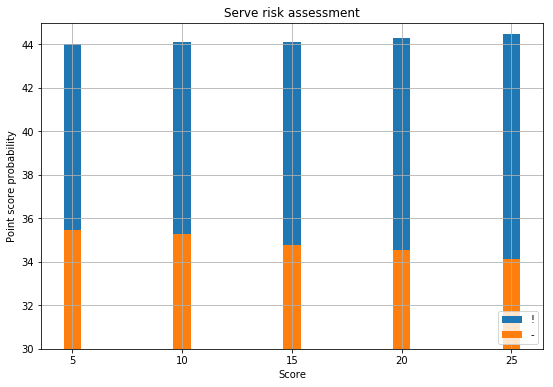

In [94]:
values = np.zeros([5,3])
print('\nHome - serve by score:')
i = 0
for score in range(5,26,5):
    cond = (vb['ActionType0']=='S') & (vb['ActionOutcome0']=='-') & (vb['ActionHome0']==1) & (vb['ScoreMax']<score) & (vb['ScoreMax']>=score-5)
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (score, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))
    values[i,0] = 50+50*np.mean(q_values[cond])
    i+=1

print('\nHome ! serve by score:')
i = 0
for score in range(5,26,5):
    cond = (vb['ActionType0']=='S') & (vb['ActionOutcome0']=='!') & (vb['ActionHome0']==1) & (vb['ScoreMax']<score) & (vb['ScoreMax']>=score-5)
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (score, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))
    values[i,1] = 50+50*np.mean(q_values[cond])
    i+=1

print('\nHome + serve by score:')
i = 0
for score in range(5,26,5):
    cond = (vb['ActionType0']=='S') & (vb['ActionOutcome0']=='+') & (vb['ActionHome0']==1) & (vb['ScoreMax']<score) & (vb['ScoreMax']>=score-5)
    print('%s: avg probability %.1f%% (from data: %.1f%% out of %d)' % \
          (score, 50+50*np.mean(q_values[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))
    values[i,2] = 50+50*np.mean(q_values[cond])
    i+=1

import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))
plt.title('Serve risk assessment')
plt.ylabel('Point score probability')
plt.xlabel('Score')
plt.grid(True)
#plt.bar([5,10,15,20,25], values[:,2])
plt.bar([5,10,15,20,25], values[:,1])
plt.bar([5,10,15,20,25], values[:,0])
plt.legend(['!','-'],loc='lower right')
plt.ylim(30,45)
plt.show()

##### Action impact calculation

In [8]:
n = 0
prevDist = -1
prevQ = 0
impact = np.zeros(len(vb))

home_default = np.mean(q_values_2[(vb.ActionHome0==1)&(vb.ActionType0=='S')])
away_default = np.mean(q_values_2[(vb.ActionAway0==1)&(vb.ActionType0=='S')])

for i in range(len(vb)): 
    if vb.RewardDistance[i] < prevDist:
        prevQ = q_values[i-1]
    else:
        if vb.ActionHome0[i]==1:
            prevQ = home_default
        else:
            prevQ = away_default
        
    impact[i] = q_values_2[i]-prevQ
    if vb.ActionAway0[i]==1:
        impact[i] = -impact[i]
        
    prevDist = vb.RewardDistance[i]
print('Impact calculation completed')

Impact calculation completed


In [11]:
# Team impact
player_impact = {}
for player in vb.PlayerTeam.unique():
    if len(vb[vb.PlayerTeam==player]) > 2000:
        player_impact[player] = np.mean(impact[vb.PlayerTeam==player])
    
srt_impacts = {k: v for k, v in sorted(player_impact.items(), key=lambda item: item[1], reverse=True)}
for k in srt_impacts.keys():
    print(k, srt_impacts[k])

Trinity Western 0.03019187719303909
Alberta 0.024610840199417762
UBC 0.01654527637307905
Brandon 0.009564657105008962
Calgary 0.007327354149008526
Winnipeg 0.005124348982499403
Mount Royal -0.006115689883630021
Manitoba -0.007400952638312637
Thompson Rivers -0.010765721096558217
MacEwan -0.017824355300718898
UBCO -0.021225843365678815
Saskatchewan -0.023484047937359538


In [12]:
# Player impact
player_impact = {}
for player in vb.PlayerName.unique():
    if len(vb[vb.PlayerName==player]) > 500:
        player_impact[player] = np.mean(impact[vb.PlayerName==player])
    
srt_impacts = {k: v for k, v in sorted(player_impact.items(), key=lambda item: item[1], reverse=True)}
for k in srt_impacts.keys():
    print(k, srt_impacts[k])

Eric Loeppky 0.08795947560234542
Elliot Viles 0.08616441111641569
Jackson Kennedy 0.06542580227211904
George Hobern 0.0635420416511722
Jordan Canham 0.05523940326698811
Arran Chambers 0.05381455453506029
Joel Regher 0.05356467718427831
Hamish Hazelden 0.05227813108627029
Gerard Murray 0.05157927073233357
Daniel Thiessen 0.0507779345614234
Alex Bader 0.04295735950127836
Mitchell Higgin 0.042954402987408755
Jordan Deshane 0.04239480871189084
Tim Dobbert 0.03964482072378537
Byron Keturakis 0.03849196341290328
Matthew Neaves 0.03750897424339341
Daulton Sinoski 0.036444099657159265
Tim Taylor 0.034667685953499935
Pearson Eshenko 0.03354715393637592
Alex McMullin 0.03038117625504915
Fynn McCarthy 0.030342271604375328
Jacob Kern 0.030017427027594766
Max Vriend 0.028689506594781523
Tyler Schmidt 0.02790610889241714
Irvandeep Brar 0.027239829276872594
Connor Murray 0.02548578681600423
Keith West 0.025291558637186254
Jesse Elser 0.024662006083227068
Mathew Guidi 0.024032137386825685
Michael Dowh

In [59]:
for action in ['S','R','E','A','B','D','F']:
    print(action, np.mean(impact[(vb.PlayerTeam=='Brandon')&(vb.ActionType0==action)]))

S 0.008225415998385338
R 0.0004132612417793642
E -0.056165834987329924
A 0.07156828746477645
B -0.028465171267169638
D -0.009190209054217987
F -0.7499313103525262


#### Distance from end of rally comparison

In [21]:
y_prob_tree = pickle.load(open('../output/y_probabilities_tree.pkl', 'rb'))
y_mimic = pickle.load(open('../output/y_probabilities_mimictree.pkl', 'rb'))
true_prob = np.zeros([len(vb),2])
true_prob[:,0] = .5-.5*vb.RewardValue
true_prob[:,1] = 1 - true_prob[:,0]
nn_prob = np.zeros([len(vb),2])
nn_prob[:,0] = .5-.5*q_values
nn_prob[:,1] = 1 - nn_prob[:,0]
mimic_prob = np.zeros([len(vb),2])
mimic_prob[:,0] = .5-.5*y_mimic
mimic_prob[:,1] = 1 - mimic_prob[:,0]

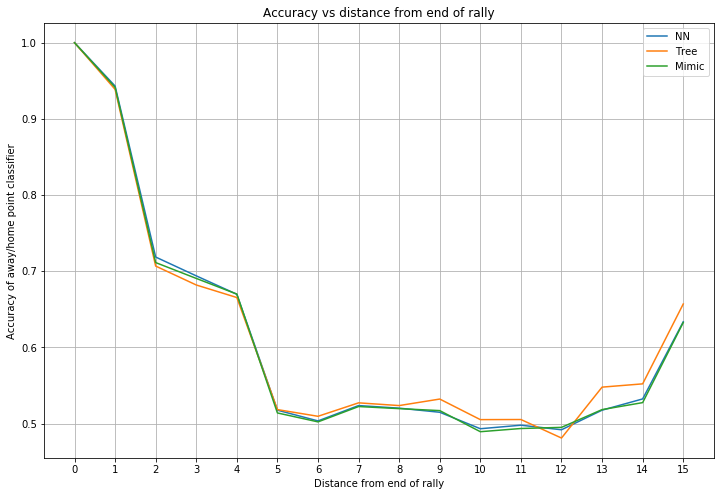

In [43]:
import matplotlib.pyplot as plt
accs_nn = []
accs_tree = []
accs_mimic = []
max_dist = 15
for dist in range(0,max_dist+1):
    cond = (vb.RewardDistance == dist)
    #print('\nTree accuracy for distance %d: %.4f' % (dist, metrics.accuracy_score(tree_pred[cond], vb.RewardValue[cond])))
    #print('NN accuracy for distance %d: %.4f' % (dist, metrics.accuracy_score(nn_pred[cond], vb.RewardValue[cond])))
    accs_tree.append(metrics.roc_auc_score(true_prob[cond], y_prob_tree[cond]))
    accs_nn.append(metrics.roc_auc_score(true_prob[cond], nn_prob[cond]))
    accs_mimic.append(metrics.roc_auc_score(true_prob[cond], mimic_prob[cond]))
plt.figure(figsize=(12,8))
plt.title('Accuracy vs distance from end of rally')
plt.grid(True)
plt.xticks(range(0,max_dist+1))
plt.xlabel('Distance from end of rally')
plt.ylabel('Accuracy of away/home point classifier')
plt.plot(range(0,max_dist+1), accs_nn)
plt.plot(range(0,max_dist+1), accs_tree)
plt.plot(range(0,max_dist+1), accs_mimic)
plt.legend(['NN','Tree','Mimic'])
plt.show()

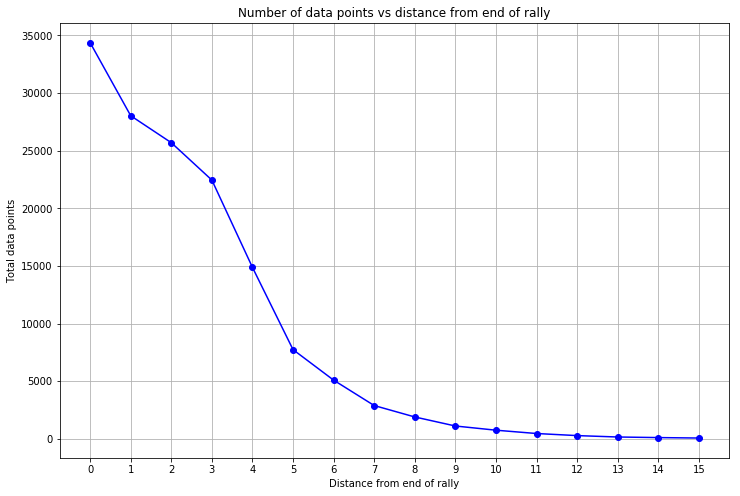

[34371, 28031, 25693, 22448, 14871, 7735, 5088, 2884, 1893, 1109, 745, 457, 276, 155, 104, 65]


In [44]:
import matplotlib.pyplot as plt
totals = []
max_dist = 15
for dist in range(0,max_dist+1):
    cond = (vb.RewardDistance == dist)
    totals.append(np.sum(cond))
plt.figure(figsize=(12,8))
plt.title('Number of data points vs distance from end of rally')
plt.grid(True)
plt.xticks(range(0,max_dist+1))
plt.xlabel('Distance from end of rally')
plt.ylabel('Total data points')
plt.plot(range(0,max_dist+1), totals, 'bo-')
plt.show()
print(totals)

In [4]:
q_values_raw_2 = pickle.load(open('../output_retry_15/q_values_before.pkl', 'rb'))
q_values_2 = np.asarray([q_values_raw_2[i,0] for i in range(len(q_values_raw_2))])
# clipping
q_values_2[q_values_2>1] = 1
q_values_2[q_values_2<-1] = -1

In [6]:
for action in ['S','R','A','E','B','D']:
    print('\nSkill:', action)
    
    count = 0
    
    outcome_regex = '[\+\!\-]'
    if action=='B':
        outcome_regex = '[\+\!]'
    elif action=='R':
        outcome_regex = '[\+\!\#\-]'
    elif action=='D':
        outcome_regex = '[\!\#]'
    
    outcome_cond0 = pd.Series(vb['ActionOutcome0']).str.match(outcome_regex)
    outcome_cond1 = pd.Series(vb['ActionOutcome1']).str.match(outcome_regex)
    
    cond0 = (vb['ActionType0']==action) & (vb['ActionHome0']==1) & (outcome_cond0)
    cond1 = (vb['ActionType1']==action) & (vb['ActionHome1']==1) & (outcome_cond1)

    if sum(cond0) != sum(cond1):
        print(sum(cond0),sum(cond1))
        continue

    if sum(cond1) == 0:
        continue

    tree_total = np.abs(np.mean(q_tree[cond1]) - np.mean(q_tree[cond0]))
    nn1_total = np.abs(np.mean(q_values[cond1]) - np.mean(q_values[cond0]))
    nn2_total = np.abs(np.mean(q_values_2[cond1]) - np.mean(q_values_2[cond0]))
    forest_total = np.abs(np.mean(q_forest[cond1]) - np.mean(q_forest[cond0]))
    mimic_total = np.abs(np.mean(q_mimic[cond1]) - np.mean(q_mimic[cond0]))

    count += sum(cond0)
        
    print('Tree: %.5f' % (tree_total))
    print('NN1: %.5f' % (nn1_total))
    print('NN2: %.5f' % (nn2_total))
    print('Forest: %.5f' % (forest_total))
    print('Mimic: %.5f'% (mimic_total))


Skill: S
Tree: 0.01584
NN1: 0.00018
NN2: 0.00006
Forest: 0.01723
Mimic: 0.00006

Skill: R
Tree: 0.01509
NN1: 0.00327
NN2: 0.00051
Forest: 0.01825
Mimic: 0.00008

Skill: A
Tree: 0.03759
NN1: 0.00870
NN2: 0.00027
Forest: 0.00748
Mimic: 0.00755

Skill: E
Tree: 0.00741
NN1: 0.02313
NN2: 0.00194
Forest: 0.00662
Mimic: 0.00178

Skill: B
Tree: 0.06413
NN1: 0.01747
NN2: 0.00084
Forest: 0.00250
Mimic: 0.01253

Skill: D
Tree: 0.06620
NN1: 0.01767
NN2: 0.00020
Forest: 0.01476
Mimic: 0.00086


In [10]:
print('Mean squared error for NN 1: %.3f' % (metrics.mean_squared_error(vb.RewardValue,q_values)))
print('Mean squared error for NN 2: %.3f' % (metrics.mean_squared_error(vb.RewardValue,q_values_2)))
print('Mean squared error for Classifier Tree: %.3f' % (metrics.mean_squared_error(vb.RewardValue,q_tree)))
print('Mean squared error for Mimic Tree: %.3f' % (metrics.mean_squared_error(vb.RewardValue,q_mimic)))
print('Mean squared error for Forest: %.3f' % (metrics.mean_squared_error(vb.RewardValue,q_forest)))
print('\n')
print('ROC-AUC score for NN 1: %.3f' % (metrics.roc_auc_score(vb.RewardValue,q_values)))
print('ROC-AUC score for NN 2: %.3f' % (metrics.roc_auc_score(vb.RewardValue,q_values_2)))
print('ROC-AUC score for Classifier Tree: %.3f' % (metrics.roc_auc_score(vb.RewardValue,q_tree)))
print('ROC-AUC score for Mimic Tree: %.3f' % (metrics.roc_auc_score(vb.RewardValue,q_mimic)))
print('ROC-AUC score for Forest: %.3f' % (metrics.roc_auc_score(vb.RewardValue,q_forest)))

Mean squared error for NN 1: 0.605
Mean squared error for NN 2: 0.603
Mean squared error for Classifier Tree: 0.613
Mean squared error for Mimic Tree: 0.606
Mean squared error for Forest: 0.592


ROC-AUC score for NN 1: 0.853
ROC-AUC score for NN 2: 0.854
ROC-AUC score for Classifier Tree: 0.849
ROC-AUC score for Mimic Tree: 0.852
ROC-AUC score for Forest: 0.862


In [5]:
nn2_pred = np.sign(q_values_2)
print(metrics.accuracy_score(vb.RewardValue, nn2_pred))

0.7550770284149264


In [13]:
for outcome in ['=','-','!','+','#']:
    cond = (vb['ActionType0']=='S') & (vb['ActionOutcome0']==outcome) & (vb['ActionHome0']==1)
    print('%s: avg probability %.2f (from data: %.1f%% out of %d)' % \
          (outcome, np.mean(q_values_2[cond], axis=0), 50+50*np.mean(vb_c.RewardValue[cond], axis=0), sum(cond)))

=: avg probability -1.00 (from data: 0.0% out of 3227)
-: avg probability -0.29 (from data: 35.4% out of 7929)
!: avg probability -0.10 (from data: 44.7% out of 2064)
+: avg probability 0.22 (from data: 61.9% out of 3084)
#: avg probability 1.00 (from data: 100.0% out of 1266)
